In [1]:
#!pip uninstall supervision --y
#!pip install -U supervision
!pip install --upgrade supervision --quiet
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
import requests
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import os
import time
import yaml
import numpy as np
import cv2
import matplotlib.pyplot as plt
import transformers
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import torchvision
from supervision import Detections, BoxAnnotator
import supervision as sv
#Visualisation
import random
import cv2
import numpy as np

# Détection du device (GPU si dispo, sinon CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 3.8 MB/s eta 0:00:00a 0:00:01


In [2]:
import supervision as sv
import transformers

sv.__version__ , transformers.__version__

('0.25.1', '4.47.0')

In [3]:

model_name = "model_detr_augmented"
PATH = "/kaggle/input/seatbelt-helmet-detection-detr/Seatbelt Helmet Detection.v6i.coco_augmented"
CLASS_NAME = ['0', 'car', 'helmet', 'license plate', 'motorcycle', 
                'no helmet', 'no seat belt', 'person', 'seatbelt']

TRAIN_DIRECTORY = os.path.join(PATH, "train")
VAL_DIRECTORY = os.path.join(PATH, "valid")
TEST_DIRECTORY = os.path.join(PATH, "test")


ANNOTATION_FILE_NAME = "_annotations.coco.json"

In [ ]:
image_processor = DetrImageProcessor.from_pretrained(
    "facebook/detr-resnet-50",
    size={"shortest_edge": 480, "longest_edge": 640} 
)

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

In [5]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self, 
        image_directory_path: str, 
        image_processor, 
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)        
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


In [6]:
TRAIN_DATASET = CocoDetection(image_directory_path=TRAIN_DIRECTORY, image_processor=image_processor, train=True)
VAL_DATASET = CocoDetection(image_directory_path=VAL_DIRECTORY, image_processor=image_processor, train=False)
TEST_DATASET = CocoDetection(image_directory_path=TEST_DIRECTORY, image_processor=image_processor, train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 6014
Number of validation examples: 452
Number of test examples: 166


In [7]:
def coco_annotations_to_detections(annotations):
    boxes_xyxy = []
    class_ids = []

    for ann in annotations:
        if "bbox" in ann:
            x, y, w, h = ann["bbox"]
            boxes_xyxy.append([x, y, x + w, y + h])
            class_ids.append(ann["category_id"])

    if not boxes_xyxy:
        raise ValueError("Aucune bbox valide trouvée dans les annotations")

    return Detections(
        xyxy=np.array(boxes_xyxy, dtype=np.float32),
        class_id=np.array(class_ids, dtype=int)
    )

Image #4727


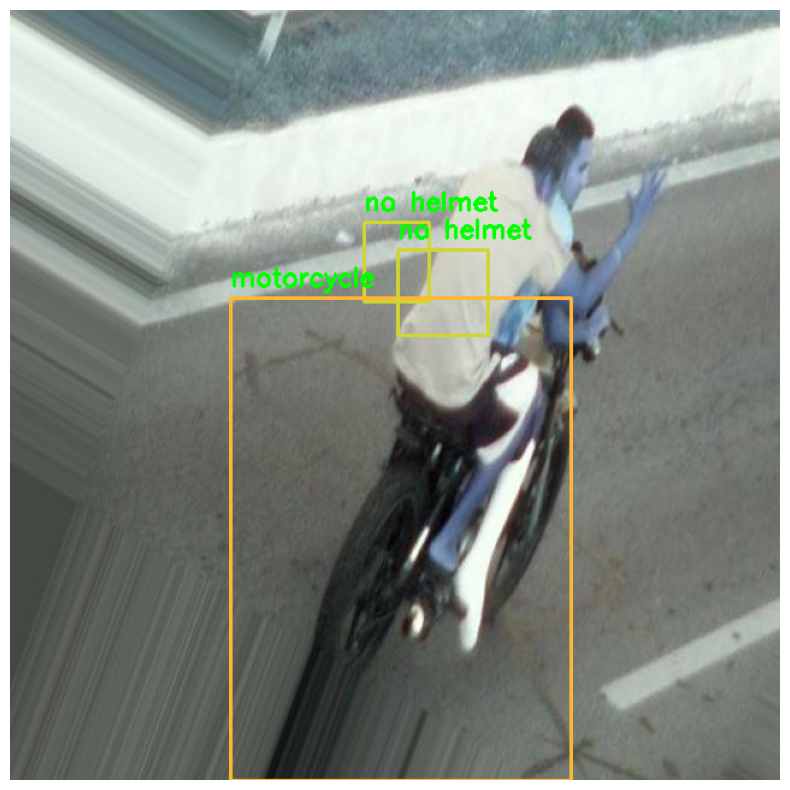

In [8]:
# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
if not annotations:
    raise ValueError(f"Aucune annotation trouvée pour l'image {image_id}")

image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)


# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

# annotate
detections = coco_annotations_to_detections(annotations)
detections.data["class_name"] = [id2label[class_id] for class_id in detections.class_id]

# === Annotation avec BoxAnnotator ===
box_annotator = BoxAnnotator()
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections)

# === Ajout manuel du texte (labels) avec OpenCV ===
for box, label in zip(detections.xyxy, detections.data["class_name"]):
    x1, y1, _, _ = map(int, box)
    cv2.putText(
        annotated_frame, label, (x1, y1 - 10),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.7, color=(0, 255, 0), thickness=2
    )

# === Affichage final ===
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [9]:
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

In [10]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=8, shuffle=True, num_workers=2)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=8)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=8)

In [ ]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path="facebook/detr-resnet-50", 
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )
        
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())
            
        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here: 
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

In [12]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [ ]:
import time
from pytorch_lightning import Trainer
from IPython.display import FileLink
from pytorch_lightning.loggers import TensorBoardLogger


# settings
MAX_EPOCHS = 20

# Start timer
start_time = time.time()
logger = TensorBoardLogger("lightning_logs", name="detr_model")

trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    logger=logger,
    val_check_interval=0.5,
    gradient_clip_val=0.1,
    accumulate_grad_batches=8,
    log_every_n_steps=5,
    precision=16,
    accelerator="gpu",
    devices=1
)

trainer.fit(model)

# Stop timer
end_time = time.time()

# Calculate the time taken
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

# Save the model
model.model.save_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:572: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training time: 4856.65 seconds


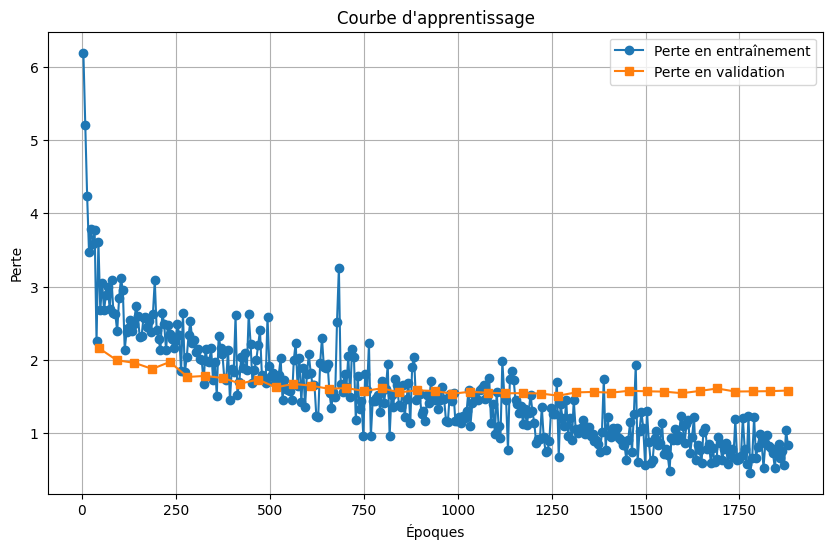

In [14]:
import os
from tensorboard.backend.event_processing import event_accumulator

def plot_learning_curve_from_log(log_dir):
    # Trouver le fichier event
    event_path = None
    for root, dirs, files in os.walk(log_dir):
        for file in files:
            if file.startswith("events.out.tfevents"):
                event_path = os.path.join(root, file)
                break
        if event_path:
            break

    if not event_path:
        print("Aucun fichier de log TensorBoard trouvé.")
        return

    # Charger les logs
    ea = event_accumulator.EventAccumulator(event_path)
    ea.Reload()

    tags = ea.Tags()['scalars']
    if "training_loss" not in tags and "validation/loss" not in tags:
        print("Métriques non trouvées dans le fichier de log.")
        return

    # Extraire les données
    train_loss = ea.Scalars("training_loss") if "training_loss" in tags else []
    val_loss = ea.Scalars("validation/loss") if "validation/loss" in tags else []

    # Tracer
    plt.figure(figsize=(10, 6))

    if train_loss:
        plt.plot([x.step for x in train_loss], [x.value for x in train_loss], label="Perte en entraînement", marker="o")
    if val_loss:
        plt.plot([x.step for x in val_loss], [x.value for x in val_loss], label="Perte en validation", marker="s")

    plt.xlabel("Époques")
    plt.ylabel("Perte")
    plt.title("Courbe d'apprentissage")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_learning_curve_from_log("/kaggle/working/lightning_logs/detr_model")


In [15]:
FileLink("/kaggle/working.zip")
print(os.listdir("/kaggle/working/lightning_logs"))

['detr_model']


In [16]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self, 
        image_directory_path: str, 
        image_processor, 
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        # Appel correct du constructeur parent
        torchvision.datasets.CocoDetection.__init__(self, image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        # Utiliser la méthode de la classe parente correctement
        images, annotations = torchvision.datasets.CocoDetection.__getitem__(self, idx)        
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target

In [17]:
# Réinstancier les datasets avec la classe corrigée
TRAIN_DATASET = CocoDetection(image_directory_path=TRAIN_DIRECTORY, image_processor=image_processor, train=True)
VAL_DATASET = CocoDetection(image_directory_path=VAL_DIRECTORY, image_processor=image_processor, train=False)
TEST_DATASET = CocoDetection(image_directory_path=TEST_DIRECTORY, image_processor=image_processor, train=False)

# Réinstancier les dataloaders
TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=8, shuffle=True, num_workers=2)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=8)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=8)

loading annotations into memory...
Done (t=0.59s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


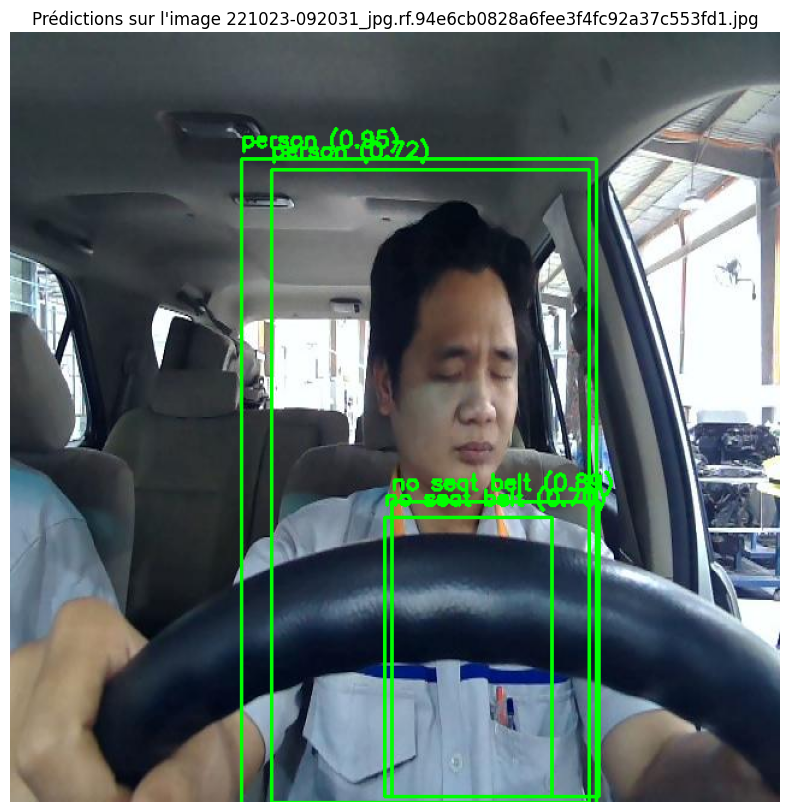

In [18]:
from transformers import DetrImageProcessor

image_ids = TEST_DATASET.coco.getImgIds()
random_idx = random.randint(0, len(TEST_DATASET) - 1)  # plus fiable que random.choice

image_id = TEST_DATASET.ids[random_idx]
image_info = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
if not annotations:
    raise ValueError(f"Aucune annotation trouvée pour l'image {image_id}")

image_path = os.path.join(TEST_DATASET.root, image_info["file_name"])
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



# Taille cible identique à l'entraînement
encoding = image_processor(images=image_rgb, return_tensors="pt")
pixel_values = encoding["pixel_values"].to(model.device)
pixel_mask = encoding["pixel_mask"].to(model.device)

model.eval()
with torch.no_grad():
    outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
    # Taille d'origine de l'image (en H, W)
    target_size = torch.tensor([image.shape[:2]], device=model.device)
    
    # Post-traitement pour obtenir les résultats formatés
    results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_size)[0]
    
    pred_boxes = results["boxes"].cpu().numpy()
    pred_labels = results["labels"].cpu().numpy()
    pred_scores = results["scores"].cpu().numpy()

def draw_boxes_opencv(image, boxes, labels, scores=None, color=(0, 255, 0)):
    """Dessine les boîtes avec OpenCV"""
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        label = id2label.get(labels[i], str(labels[i]))
        if scores is not None:
            label = f"{label} ({scores[i]:.2f})"
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, color, 2)
    return image

image_annotated = draw_boxes_opencv(image.copy(), pred_boxes, pred_labels, pred_scores)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_annotated, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"Prédictions sur l'image {image_info['file_name']}")
plt.show()

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
import seaborn as sns
from tqdm.auto import tqdm

In [20]:
def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    device = next(model.parameters()).device  # On détermine le device à partir du modèle
    
    all_gt_boxes = []
    all_gt_labels = []
    all_pred_boxes = []
    all_pred_labels = []
    all_pred_scores = []
    
    # Pour les courbes P-R
    y_true_flat = []
    y_scores_flat = []
    y_labels_flat = []
    
    for batch_idx, batch in enumerate(tqdm(dataloader, desc="Évaluation")):
        # Vérifier le format du batch et l'adapter
        if isinstance(batch, dict):
            # Format de type dict avec clés spécifiques
            pixel_values = batch.get("pixel_values", batch.get("images", None))
            pixel_mask = batch.get("pixel_mask", None)
            targets = batch.get("labels", batch.get("targets", None))
        elif isinstance(batch, tuple) and len(batch) == 2:
            # Format standard (pixel_values, targets)
            pixel_values, targets = batch
        elif isinstance(batch, tuple) and len(batch) == 3:
            # Format étendu (pixel_values, pixel_mask, targets)
            pixel_values, pixel_mask, targets = batch
        elif isinstance(batch, tuple) and len(batch) > 3:
            # Format avec plus d'éléments - adapter selon votre cas
            pixel_values = batch[0]
            targets = batch[1] if len(batch) > 1 else None
        else:
            # Si c'est un autre format, afficher un message et passer au batch suivant
            print(f"Format de batch non reconnu: {type(batch)}")
            if isinstance(batch, tuple):
                print(f"Nombre d'éléments dans le tuple: {len(batch)}")
            continue
            
        # Préparation des entrées (assurez-vous qu'ils sont sur le bon device)
        if pixel_values is not None:
            pixel_values = pixel_values.to(device)
        
        # Si vous avez plusieurs images par batch
        batch_size = pixel_values.shape[0]
        
        with torch.no_grad():
            # Assurez-vous que votre modèle accepte le format des entrées correctement
            outputs = model(pixel_values=pixel_values, pixel_mask=batch.get("pixel_mask", None).to(device) if batch.get("pixel_mask", None) is not None else None)
        
        # Post-processing
        # Obtenez les tailles originales des images si disponibles, sinon utilisez la taille des features
        # C'est ici qu'on adapte le code
        target_sizes = []
        for i in range(batch_size):
            # Vérifiez si le target contient déjà cette information
            if hasattr(targets[i], "get") and targets[i].get("original_size") is not None:
                target_sizes.append(targets[i]["original_size"].to(device))
            else:
                # Utilisez la taille de l'image en entrée comme estimation
                # Notez que DETR attend généralement [height, width]
                h, w = pixel_values[i].shape[-2:]  # [C, H, W]
                target_sizes.append(torch.tensor([h, w], device=device))
        
        # Si votre modèle possède une méthode post_process_object_detection
        results = image_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=threshold)
        
        # Traitement des résultats
        for i in range(batch_size):
            target = targets[i]
            
            # Ground truth
            # Adaptez ces lignes en fonction de la structure de vos targets
            if isinstance(target, dict):
                gt_boxes = target.get("boxes", torch.tensor([])).cpu().numpy()
                gt_labels = target.get("labels", torch.tensor([])).cpu().numpy()
                # Si vous utilisez "class_labels" au lieu de "labels"
                if len(gt_labels) == 0 and "class_labels" in target:
                    gt_labels = target["class_labels"].cpu().numpy()
            else:
                # Si target n'est pas un dictionnaire, essayez d'accéder aux attributs
                gt_boxes = getattr(target, "boxes", torch.tensor([])).cpu().numpy()
                gt_labels = getattr(target, "labels", torch.tensor([])).cpu().numpy()
                if len(gt_labels) == 0 and hasattr(target, "class_labels"):
                    gt_labels = target.class_labels.cpu().numpy()
            
            # Predictions
            result = results[i]
            if len(result["scores"]) > 0:
                pred_boxes = result["boxes"].cpu().numpy()
                pred_labels = result["labels"].cpu().numpy()
                pred_scores = result["scores"].cpu().numpy()
            else:
                pred_boxes = np.array([])
                pred_labels = np.array([])
                pred_scores = np.array([])
            
            # Stocker les résultats
            all_gt_boxes.append(gt_boxes)
            all_gt_labels.append(gt_labels)
            all_pred_boxes.append(pred_boxes)
            all_pred_labels.append(pred_labels)
            all_pred_scores.append(pred_scores)
            
            # Pour les courbes P-R et ROC (one-hot encoding)
            # Assurez-vous que id2label est défini et accessible
            num_classes = max(list(id2label.keys())) if 'id2label' in globals() else max(gt_labels.max(), pred_labels.max() if len(pred_labels) > 0 else 0)
            
            for gt_label in gt_labels:
                for c in range(1, num_classes + 1):  # Skip background class 0
                    y_true_flat.append(1 if gt_label == c else 0)
                    
                    # Trouver le score correspondant pour cette classe
                    score = 0.0
                    for pl, ps in zip(pred_labels, pred_scores):
                        if pl == c:
                            score = max(score, ps)
                    y_scores_flat.append(score)
                    y_labels_flat.append(c)
    
    return {
        "gt_boxes": all_gt_boxes,
        "gt_labels": all_gt_labels,
        "pred_boxes": all_pred_boxes,
        "pred_labels": all_pred_labels,
        "pred_scores": all_pred_scores,
        "y_true_flat": np.array(y_true_flat),
        "y_scores_flat": np.array(y_scores_flat),
        "y_labels_flat": np.array(y_labels_flat)
    }

eval_results = evaluate_model(model, TEST_DATALOADER, threshold=0.5)

Évaluation:   0%|          | 0/21 [00:00<?, ?it/s]

In [21]:
print("GT bbox exemple :", eval_results["gt_boxes"][0][0])
print("Pred bbox exemple :", eval_results["pred_boxes"][0][0])
print("Target size :", target_size)
from collections import Counter

print("Labels GT (extrait):", Counter([l for labels in eval_results["gt_labels"] for l in labels]))
print("Labels PR (extrait):", Counter([l for labels in eval_results["pred_labels"] for l in labels]))
i = 0
print("GT:", eval_results["gt_boxes"][i], eval_results["gt_labels"][i])
print("PR:", eval_results["pred_boxes"][i], eval_results["pred_labels"][i], eval_results["pred_scores"][i])


GT bbox exemple : [0.17421874 0.3890625  0.3484375  0.653125  ]
Pred bbox exemple : [ 26.386656 241.02663   65.60886  274.74417 ]
Target size : tensor([[640, 640]])
Labels GT (extrait): Counter({8: 102, 6: 40, 3: 28, 7: 28, 1: 20, 4: 14, 2: 14, 5: 4})
Labels PR (extrait): Counter({8: 144, 3: 100, 6: 76, 1: 70, 7: 46, 4: 24, 5: 6, 2: 2})
GT: [[0.17421874 0.3890625  0.3484375  0.653125  ]
 [0.14921875 0.5671875  0.0921875  0.084375  ]
 [0.25703126 0.334375   0.0453125  0.109375  ]] [1 3 6]
PR: [[ 26.386656 241.02663   65.60886  274.74417 ]
 [ 48.546013 278.2186    89.97624  310.87912 ]
 [ 99.54347  112.12265  142.35501  188.34581 ]
 [  1.317966  22.496395 201.6392   331.9381  ]
 [104.96257  121.68423  121.59272  165.96068 ]] [3 3 7 1 6] [0.5099896  0.7578345  0.87852186 0.9676781  0.7734768 ]


[]


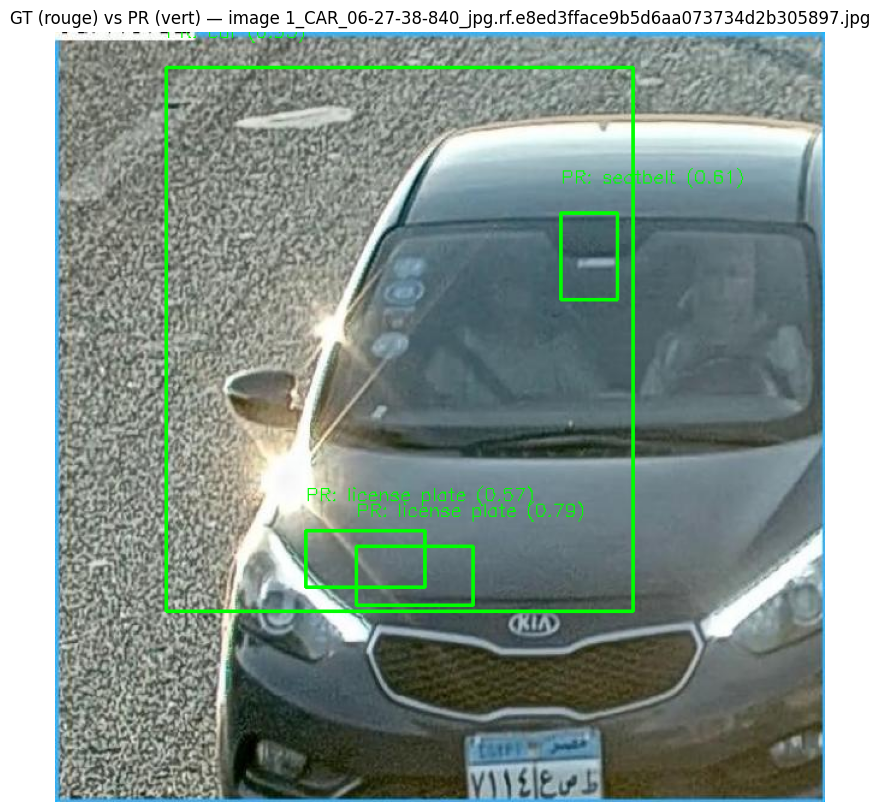

In [22]:
# --- 1. Choisir un index avec au moins une prédiction et un GT ---
image_ids = TEST_DATASET.coco.getImgIds()
idx = random.randint(0, len(TEST_DATASET) - 1)  

gt_boxes = eval_results["gt_boxes"][idx]
gt_labels = eval_results["gt_labels"][idx]

pred_boxes = eval_results["pred_boxes"][idx]
pred_labels = eval_results["pred_labels"][idx]
pred_scores = eval_results["pred_scores"][idx]

# --- 2. Charger l'image correspondante ---
image_id = TEST_DATASET.ids[idx]
image_info = TEST_DATASET.coco.loadImgs(image_id)[0]
image_path = os.path.join(TEST_DATASET.root, image_info["file_name"])
image = cv2.imread(image_path)

H, W = image.shape[:2]  # hauteur et largeur de l'image

# Correction de la conversion des coordonnées normalisées [x, y, w, h] -> [x1, y1, x2, y2]
gt_boxes_corrected = []

for box in gt_boxes:
    if np.max(box) <= 1.0:  # Si la boîte est normalisée
        x1, y1, x2, y2 = box
        x1, y1, x2, y2 = x1 * W, y1 * H, x2 * W, y2 * H
    else:
        x1, y1, x2, y2 = box  # Directement en pixels

    # Assurer que les coordonnées sont dans les limites de l'image
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(W, x2), min(H, y2)

    gt_boxes_corrected.append([x1, y1, x2, y2])

gt_boxes = np.array(gt_boxes_corrected)
print(gt_boxes)

# --- 3. Dessiner les GT (rouge) ---
for box, label in zip(gt_boxes, gt_labels):
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    cv2.putText(image, f"GT: {id2label.get(label, str(label))}", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

# --- 4. Dessiner les PR (vert) ---
for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    text = f"PR: {id2label.get(label, str(label))} ({score:.2f})"
    cv2.putText(image, text, (x1, y1 - 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

# --- 5. Affichage final ---
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"GT (rouge) vs PR (vert) — image {image_info['file_name']}")
plt.show()

In [23]:
# Fonction pour calculer l'IoU entre deux boîtes
def calculate_iou(box1, box2):
    # box format: [x1, y1, x2, y2] (en pixels)
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # Calculer l'aire de l'intersection
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    
    # Calculer l'aire de l'union
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    
    iou = intersection / union if union > 0 else 0
    return iou

# Fonction pour calculer mAP avec mise à l'échelle des boîtes GT
def calculate_map(eval_results, iou_threshold=0.05):
    class_aps = {}

    for class_id in id2label.keys():
        class_name = id2label[class_id]
        all_detections = []
        total_gt = 0

        for i in range(len(eval_results["gt_boxes"])):
            gt_boxes = eval_results["gt_boxes"][i]
            gt_labels = eval_results["gt_labels"][i]
            pred_boxes = eval_results["pred_boxes"][i]
            pred_labels = eval_results["pred_labels"][i]
            pred_scores = eval_results["pred_scores"][i]

            # Mise à l'échelle des GT si elles sont normalisées
            H, W = 640, 640  # Assure-toi que la taille de l'image est bien ici
            gt_boxes_corrected = []
            for box in gt_boxes:
                if np.max(box) <= 1.0:  # coordonnées normalisées
                    x1, y1, x2, y2 = box
                    x1, y1, x2, y2 = x1 * W, y1 * H, x2 * W, y2 * H
                else:
                    x1, y1, x2, y2 = box  # déjà en pixels
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(W, x2), min(H, y2)
                gt_boxes_corrected.append([x1, y1, x2, y2])
            gt_boxes = np.array(gt_boxes_corrected)

            # Filtrer ground truths et prédictions de cette classe
            gt_class_boxes = gt_boxes[np.where(gt_labels == class_id)]
            pred_class_boxes = pred_boxes[np.where(pred_labels == class_id)]
            pred_class_scores = pred_scores[np.where(pred_labels == class_id)]

            total_gt += len(gt_class_boxes)

            # Marquer les GT utilisés
            used = np.zeros(len(gt_class_boxes), dtype=bool)

            # Trier les prédictions par score
            sorted_indices = np.argsort(-pred_class_scores)
            pred_class_boxes = pred_class_boxes[sorted_indices]
            pred_class_scores = pred_class_scores[sorted_indices]

            for box_pred, score in zip(pred_class_boxes, pred_class_scores):
                ious = np.array([calculate_iou(box_pred, box_gt) for box_gt in gt_class_boxes])
                max_iou_idx = ious.argmax() if len(ious) > 0 else -1
                max_iou = ious[max_iou_idx] if len(ious) > 0 else 0

                if max_iou >= iou_threshold and not used[max_iou_idx]:
                    all_detections.append({"score": score, "TP": True})
                    used[max_iou_idx] = True
                else:
                    all_detections.append({"score": score, "TP": False})

        if total_gt == 0:
            class_aps[class_name] = 0.0
            continue

        # Trier toutes les détections par score
        all_detections.sort(key=lambda x: x["score"], reverse=True)

        TP, FP = 0, 0
        precisions, recalls = [], []

        for det in all_detections:
            if det["TP"]:
                TP += 1
            else:
                FP += 1

            precisions.append(TP / (TP + FP))
            recalls.append(TP / total_gt)

        # Interpolation et calcul de l'AP
        precisions = np.array(precisions)
        recalls = np.array(recalls)
        precisions = np.concatenate([[1.0], precisions, [0.0]])
        recalls = np.concatenate([[0.0], recalls, [1.0]])

        for i in range(len(precisions) - 2, -1, -1):
            precisions[i] = max(precisions[i], precisions[i + 1])

        ap = np.sum((recalls[1:] - recalls[:-1]) * precisions[1:])
        class_aps[class_name] = ap

    return class_aps


# Calcul du mAP pour l'exemple
class_aps = calculate_map(eval_results)
mAP = sum(class_aps.values()) / len(class_aps)
for class_name, ap in class_aps.items():
    print(f"{class_name}: {ap:.4f}")

0: 0.0000
car: 0.0714
helmet: 0.0000
license plate: 0.0000
motorcycle: 0.0000
no helmet: 0.0000
no seat belt: 0.0000
person: 0.0000
seatbelt: 0.0117


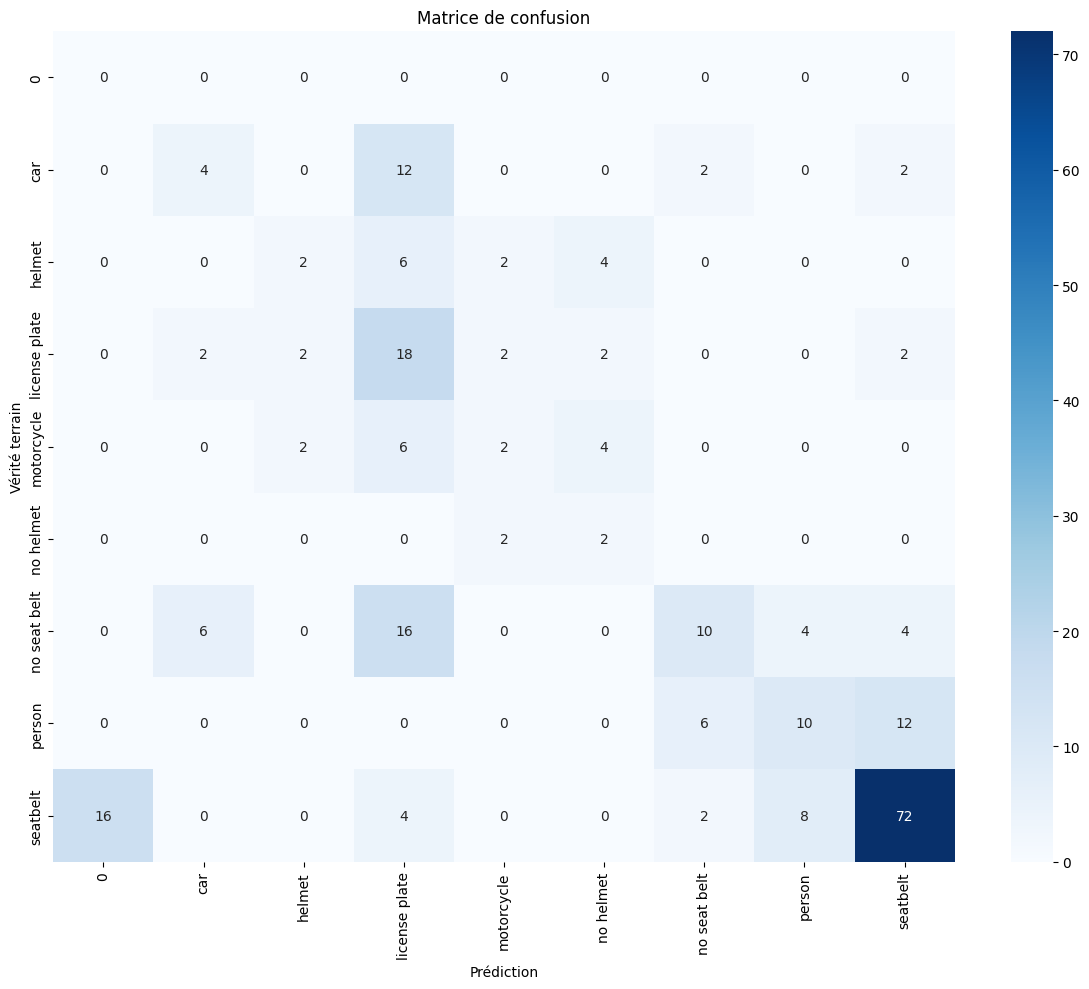

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  4,  0, 12,  0,  0,  2,  0,  2],
       [ 0,  0,  2,  6,  2,  4,  0,  0,  0],
       [ 0,  2,  2, 18,  2,  2,  0,  0,  2],
       [ 0,  0,  2,  6,  2,  4,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  2,  0,  0,  0],
       [ 0,  6,  0, 16,  0,  0, 10,  4,  4],
       [ 0,  0,  0,  0,  0,  0,  6, 10, 12],
       [16,  0,  0,  4,  0,  0,  2,  8, 72]])

In [24]:
# Fonction pour tracer la matrice de confusion
def plot_confusion_matrix(eval_results):
    # Extraire toutes les étiquettes réelles et prédites
    y_true = []
    y_pred = []
    
    for gt_labels_img, pred_boxes_img, pred_labels_img in zip(
        eval_results["gt_labels"], 
        eval_results["pred_boxes"], 
        eval_results["pred_labels"]
    ):
        # Pour chaque image, associer les prédictions aux ground truths
        if len(pred_boxes_img) > 0:
            for gt_label in gt_labels_img:
                y_true.append(gt_label)
                
                # Trouver la prédiction la plus proche
                best_pred = 0  # classe background par défaut
                if len(pred_labels_img) > 0:
                    best_pred = pred_labels_img[0]  # prendre la première prédiction par défaut
                
                y_pred.append(best_pred)
        else:
            # Pas de prédictions pour cette image
            for gt_label in gt_labels_img:
                y_true.append(gt_label)
                y_pred.append(0)  # classe background
    
    # Créer la matrice de confusion
    unique_labels = np.unique(np.concatenate([y_true, y_pred]))
    labels = [id2label.get(l, str(l)) for l in unique_labels]
    
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=labels, yticklabels=labels)
    plt.ylabel("Vérité terrain")
    plt.xlabel("Prédiction")
    plt.title("Matrice de confusion")
    plt.tight_layout()
    plt.show()
    
    return cm

plot_confusion_matrix(eval_results)

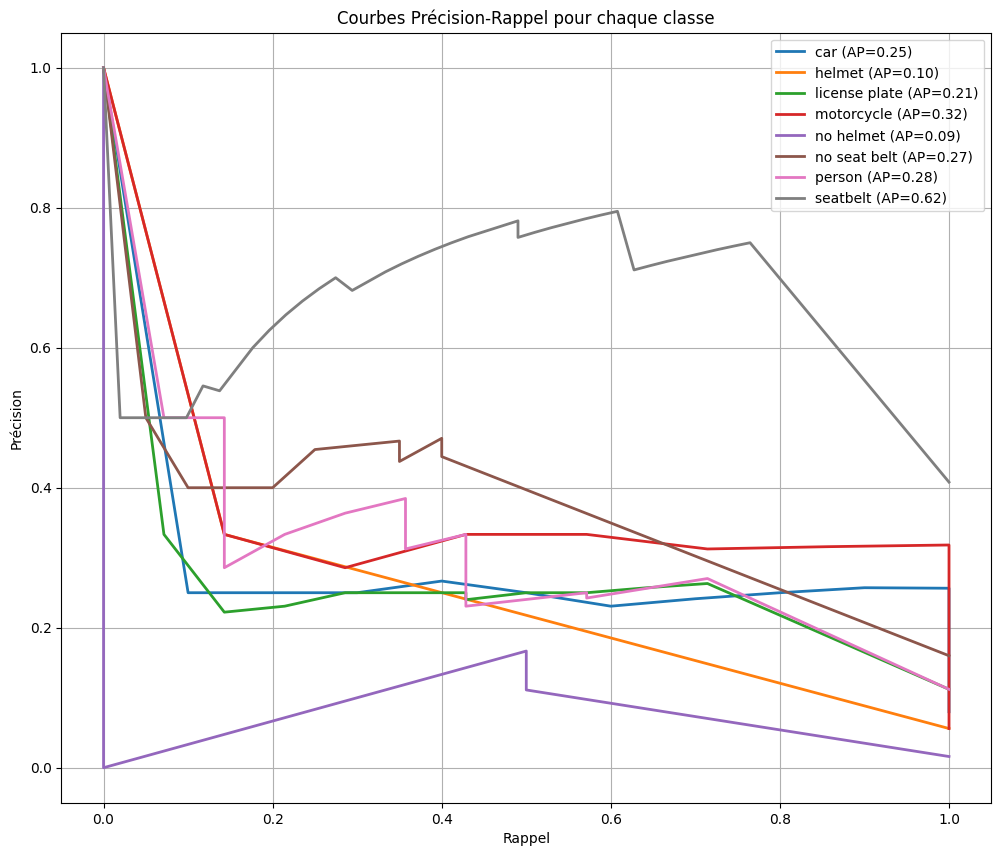

In [25]:
# Fonction pour tracer les courbes PR pour chaque classe
# Fonction pour tracer les courbes PR
def plot_pr_curves(eval_results):
    plt.figure(figsize=(12, 10))
    
    for class_id, class_name in id2label.items():
        if class_id == 0:  # ignorer background si besoin
            continue

        # Filtrer pour cette classe
        mask = eval_results["y_labels_flat"] == class_id
        if np.sum(mask) == 0:
            continue
            
        y_true = eval_results["y_true_flat"][mask]
        y_scores = eval_results["y_scores_flat"][mask]
        
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        ap = average_precision_score(y_true, y_scores)
        
        plt.plot(recall, precision, lw=2, label=f'{class_name} (AP={ap:.2f})')
    
    plt.xlabel('Rappel')
    plt.ylabel('Précision')
    plt.title('Courbes Précision-Rappel pour chaque classe')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()


plot_pr_curves(eval_results)

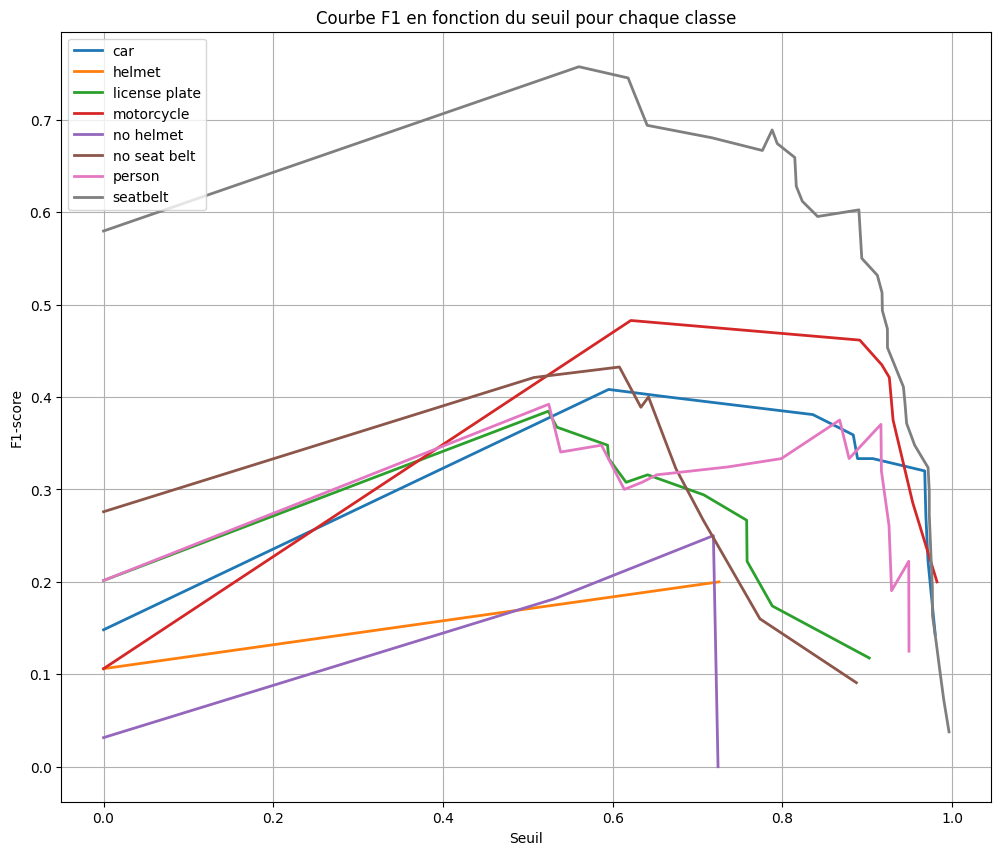

In [26]:
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour tracer la courbe F1 en fonction du seuil
def plot_f1_curve(eval_results):
    plt.figure(figsize=(12, 10))

    for class_id, class_name in id2label.items():
        if class_id == 0:  # facultatif, ignorer 'background'
            continue
        
        # Filtrer les entrées pour cette classe
        mask = eval_results["y_labels_flat"] == class_id
        if np.sum(mask) == 0:
            continue

        y_true = eval_results["y_true_flat"][mask]
        y_scores = eval_results["y_scores_flat"][mask]

        precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

        # Calcul du F1-score pour chaque seuil
        f1_scores = np.array([
            (2 * p * r) / (p + r) if (p + r) > 0 else 0
            for p, r in zip(precision, recall)
        ])

        # Les thresholds ont une longueur de len - 1 par rapport aux f1
        plt.plot(thresholds, f1_scores[:-1], lw=2, label=f"{class_name}")

    plt.xlabel("Seuil")
    plt.ylabel("F1-score")
    plt.title("Courbe F1 en fonction du seuil pour chaque classe")
    plt.grid(True)
    plt.legend()
    plt.show()


plot_f1_curve(eval_results)

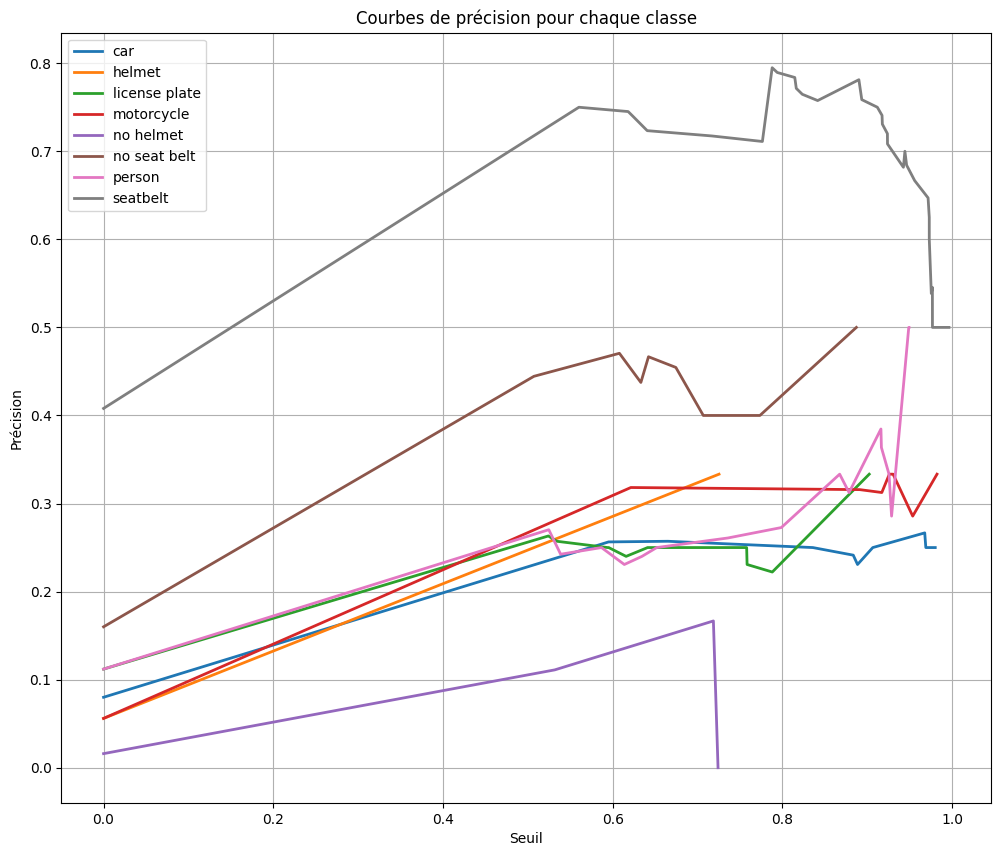

In [27]:
def plot_precision_curve(eval_results):
    plt.figure(figsize=(12, 10))

    for class_id, class_name in id2label.items():
        if class_id == 0:
            continue  # facultatif : ignorer background

        # Filtrer les prédictions de cette classe
        mask = eval_results["y_labels_flat"] == class_id
        if np.sum(mask) == 0:
            continue

        y_true = eval_results["y_true_flat"][mask]
        y_scores = eval_results["y_scores_flat"][mask]

        precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

        # tracer la précision en fonction du seuil
        plt.plot(thresholds, precision[:-1], lw=2, label=f'{class_name}')

    plt.xlabel('Seuil')
    plt.ylabel('Précision')
    plt.title('Courbes de précision pour chaque classe')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

plot_precision_curve(eval_results)


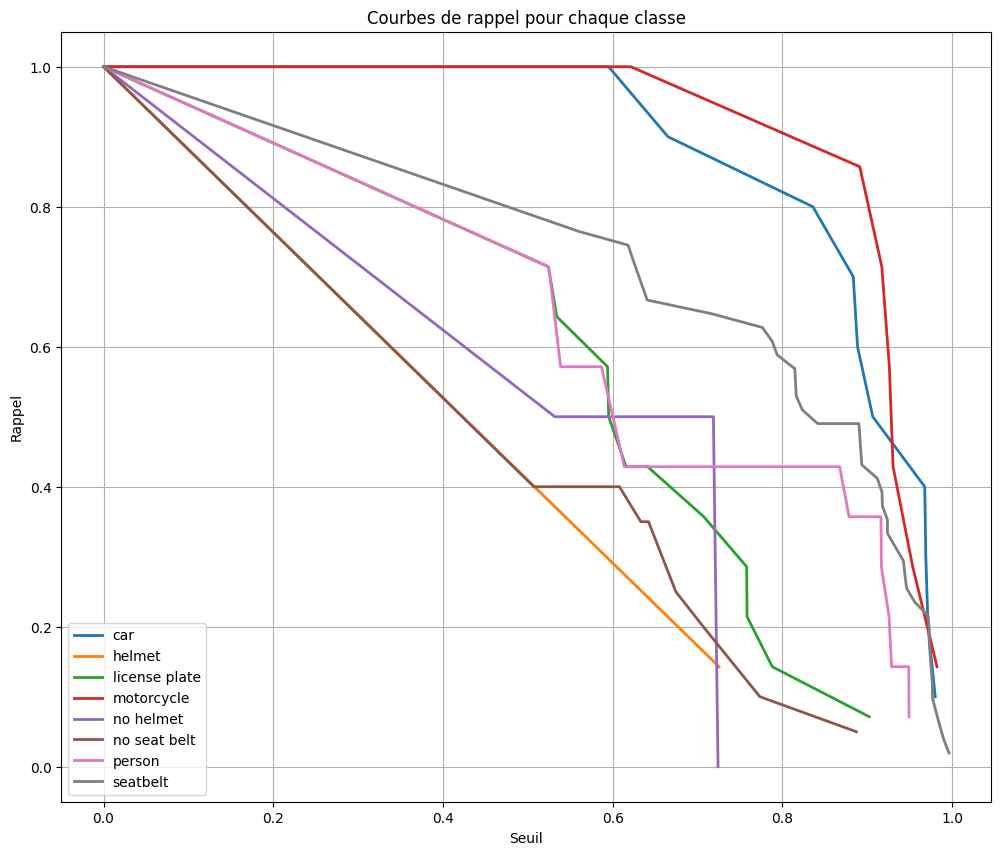

In [28]:
def plot_recall_curve(eval_results):
    plt.figure(figsize=(12, 10))

    for class_id, class_name in id2label.items():
        if class_id == 0:
            continue  # ignorer le background

        # Filtrer les exemples de cette classe
        mask = eval_results["y_labels_flat"] == class_id
        if np.sum(mask) == 0:
            continue

        y_true = eval_results["y_true_flat"][mask]
        y_scores = eval_results["y_scores_flat"][mask]

        precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

        # Tracer le rappel en fonction du seuil
        plt.plot(thresholds, recall[:-1], lw=2, label=f'{class_name}')

    plt.xlabel('Seuil')
    plt.ylabel('Rappel')
    plt.title('Courbes de rappel pour chaque classe')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

plot_recall_curve(eval_results)